In [ ]:
!pip install mlxtend


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:

import pandas as pd
from mlxtend.regressor import StackingCVRegressor
RANDOM_SEED = 42
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('ames.csv', delimiter=',')


#categoricalColumns = ["MSSubClass", "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "OverallQual", "OverallCond", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond","BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", "MiscFeature", "SaleType", "SaleCondition"]
#numericalColumns = [column for column in data.columns if column not in categoricalColumns]
categoricalColumns = data.select_dtypes(include='object').columns.to_list()
categoricalColumns = categoricalColumns + ["Year_Built", "Year_Remod_Add",
                                           "BsmtFin_SF_1", "Bsmt_Full_Bath", 
                                           "Bsmt_Half_Bath", "Full_Bath", 
                                           "Bedroom_AbvGr", "Kitchen_AbvGr", 
                                           "TotRms_AbvGrd", "Fireplaces", 
                                           "Garage_Cars", "Mo_Sold", "Year_Sold"]
numericalColumns = [column for column in data.columns if column not in categoricalColumns and column != "Sale_Price"]
for column in categoricalColumns:
    data[column] = data[column].astype('object')

#print(data[categoricalColumns].dtypes)


train = data.iloc[0:2000]
test = data.iloc[2000:]
y_train = train.Sale_Price.values
train = train.drop(["Sale_Price"], axis=1)
y_test = test["Sale_Price"].values
test = test.drop(["Sale_Price"], axis=1)
X_train = train
X_test = test

In [ ]:
y_train

array([215000, 105000, 172000, ..., 185000, 133900, 152000])

In [ ]:
rf = RandomForestRegressor(random_state=RANDOM_SEED)
lasso = Lasso(random_state=RANDOM_SEED)
ridge = Ridge(random_state=RANDOM_SEED)
svr = SVR()

In [ ]:
numericalColumnsTransformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
categoricalColumnsTransformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numericalColumnsTransformer, numericalColumns), ('cat', categoricalColumnsTransformer, categoricalColumns)])

In [ ]:
stack = StackingCVRegressor(regressors=(rf,ridge, svr), meta_regressor=lasso)
stackPipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', stack)])

In [ ]:
param_grid = {
    # Random Forest Regressor hyperparameters
    'model__randomforestregressor__n_estimators': [50, 100, 200],  # Number of trees in the forest

    # Ridge Regressor hyperparameters
    'model__ridge__alpha': [0.1, 1.0, 10.0],  # Regularization strength: smaller values specify stronger regularization

    # Support Vector Regressor hyperparameters
    'model__svr__C': [0.1, 1.0, 10.0],  # Regularization parameter: trades off correct classification of training points against maximization of the decision function's margin

    # Meta Lasso Regressor hyperparameters
    #'model__meta_lasso__alpha': [0.1, 1.0, 10.0],  # Regularization strength of the meta-regressor

    # Preprocessor hyperparameters
    #'preprocessor__num__with_mean': [True, False],  # Whether to center numerical features before scaling
    #'preprocessor__imputer__strategy': ['mean', 'median', 'most_frequent'],  # Strategy for imputing missing values in categorical features
}


In [ ]:
gridSearch = GridSearchCV(estimator=stackPipeline, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1, refit=True)

In [ ]:
gridSearch.fit(X_train, y_train)
print(f'Best Parameters: {gridSearch.best_params_ }   Score: {gridSearch.best_score_}')
#y_test_pred = gridSearch.predict(X_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'model__randomforestregressor__n_estimators': 200, 'model__ridge__alpha': 0.1, 'model__svr__C': 0.1}   Score: -26694.96761691348


In [ ]:
y_test_pred = gridSearch.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)

In [ ]:
r2

0.8359443750543394

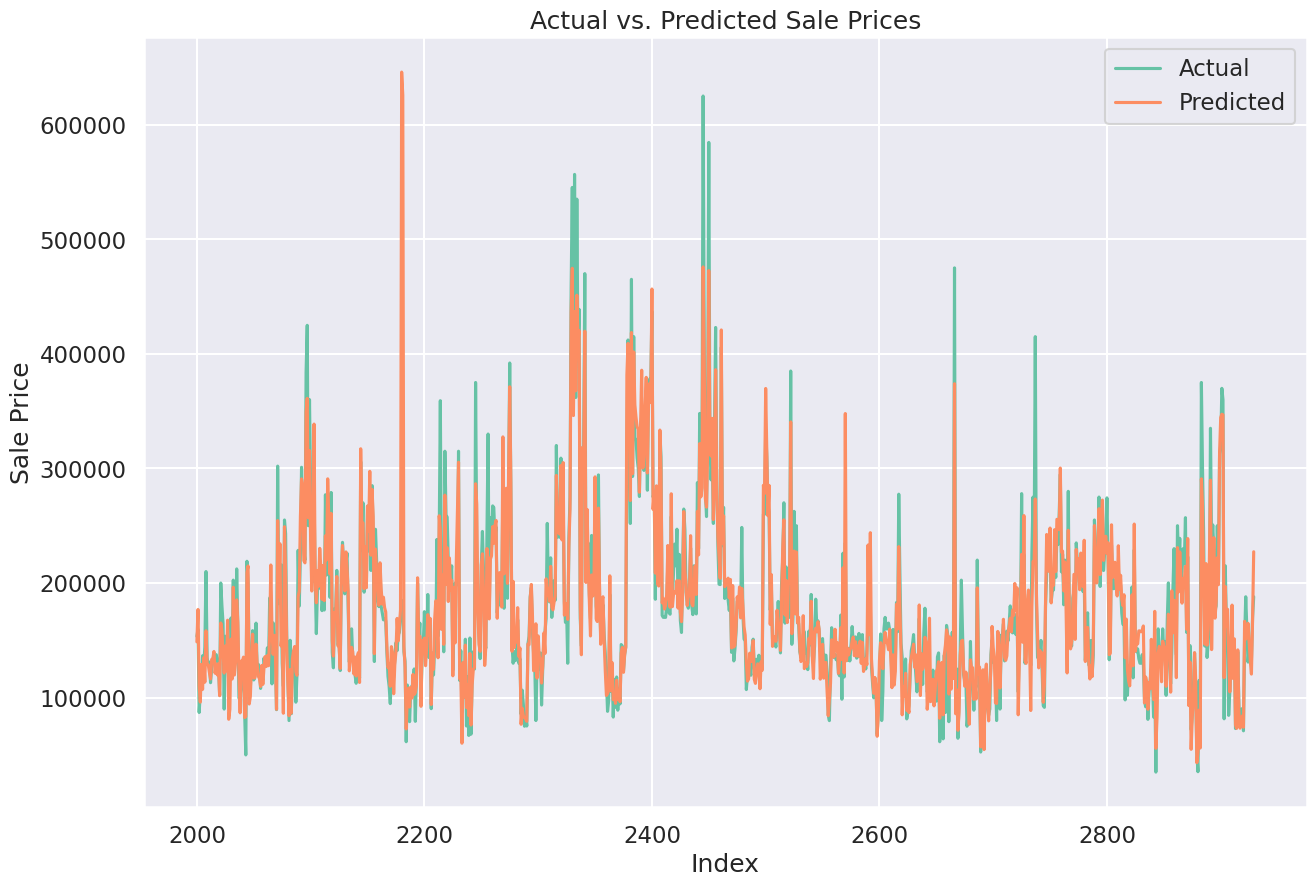

R²: 0.8359443750543394
Mean Squared Error: 972008674.3769553


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

#sns.set_style()
sns.set_theme()
sns.set_context("talk")
pastel_palette = sns.color_palette("Set2")
sns.set_palette(pastel_palette)

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(test.index, y_test, label='Actual')
ax.plot(test.index, y_test_pred, label='Predicted')

ax.set_xlabel('Index')
ax.set_ylabel('Sale Price')
ax.set_title('Actual vs. Predicted Sale Prices')
ax.legend()

plt.show()
print(f"R²: {r2}")
print(f"Mean Squared Error: {mse}")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=800d54fb-e7be-40ff-a132-718ab4a8dae0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>